* Introduce transfer learning 
* Using a smaller dataset to experiment faster 
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard

In [1]:
import datetime
print(datetime.datetime.now())

2025-07-22 18:27:46.742967


Using a GPU

In [2]:
!nvidia-smi

Tue Jul 22 18:28:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.43                 Driver Version: 566.43         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             15W /   67W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data

For many of the problems we will want to use deep learning for, chances are, a working model already exists.

And the good news is, we can access many of them on TensorFlow Hub.

TensorFlow Hub is a repository for existing model components. It makes it so we can import and use a fully trained model with as little as a URL.

Now, I really want to demonstrate the power of transfer learning to you.

To do so, what if I told you we could get much of the same results (or better) than our best model has gotten so far with only 10% of the original data, in other words, 10x less data.

This seems counterintuitive right?

Wouldn't we think more examples of what a picture of food looked like led to better results?

And we would be right if we thought so, generally, more data leads to better results.

However, what if we didn't have more data? What if instead of 750 images per class, we had 75 images per class?

Collecting 675 more images of a certain class could take a long time.

So this is where another major benefit of transfer learning comes in.

Transfer learning often allows you to get great results with less data.



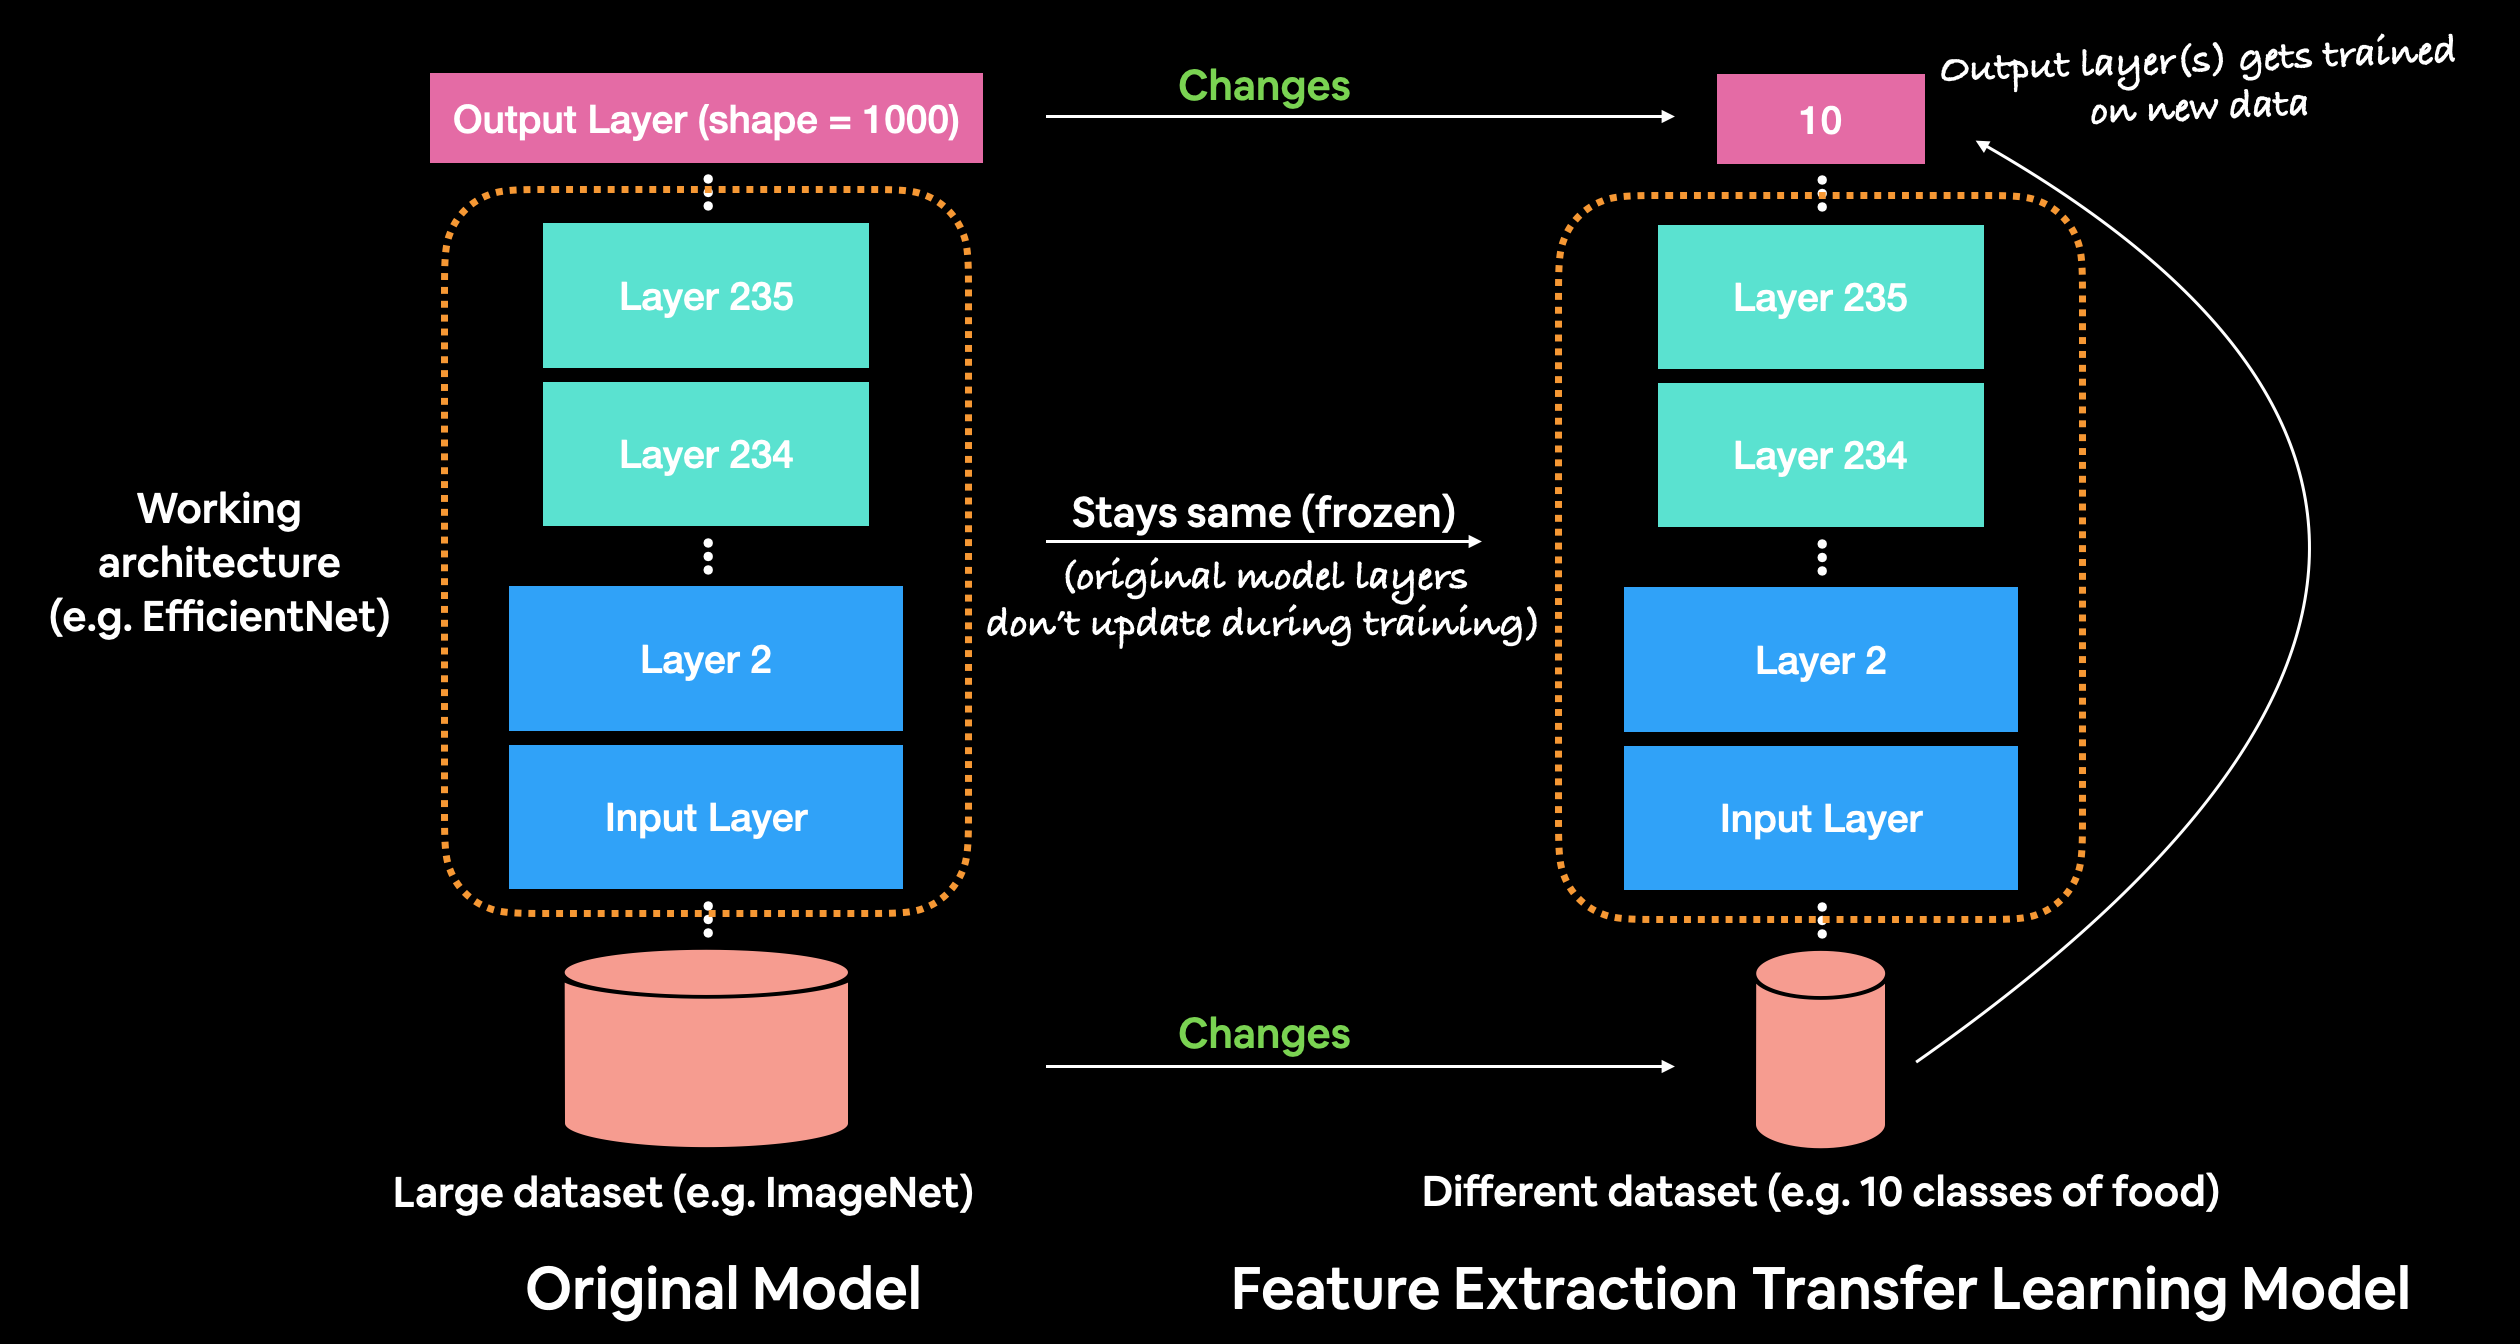

Downloading the data

In [4]:
import wget
import zipfile

# Download the zip file using Python wget
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
wget.download(url, "10_food_classes_all_data.zip")  # this saves the file

# Unzip the downloaded file
with zipfile.ZipFile("10_food_classes_all_data.zip", "r") as zip_ref:
     zip_ref.extractall()


In [5]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_all_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
    for dirname in dirnames:
        print(f"Directory: {dirname}")
    for filename in filenames:
        print(f"File: {filename}")
    print("\n")  # Add a newline for better readability

There are 2 directories and 0 images in '10_food_classes_all_data'
Directory: test
Directory: train


There are 10 directories and 0 images in '10_food_classes_all_data\test'
Directory: chicken_curry
Directory: chicken_wings
Directory: fried_rice
Directory: grilled_salmon
Directory: hamburger
Directory: ice_cream
Directory: pizza
Directory: ramen
Directory: steak
Directory: sushi


There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'
File: 101833.jpg
File: 10340.jpg
File: 1035626.jpg
File: 1048226.jpg
File: 1075859.jpg
File: 1076489.jpg
File: 108559.jpg
File: 1095245.jpg
File: 1125163.jpg
File: 1134602.jpg
File: 1147753.jpg
File: 115224.jpg
File: 1165404.jpg
File: 118944.jpg
File: 1208906.jpg
File: 1213873.jpg
File: 1215399.jpg
File: 1225331.jpg
File: 1234505.jpg
File: 1236329.jpg
File: 1237705.jpg
File: 1240973.jpg
File: 1248926.jpg
File: 1278457.jpg
File: 1318090.jpg
File: 1333857.jpg
File: 1346888.jpg
File: 1349731.jpg
File: 1351520.jpg
File: 13611

Creating data loaders

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir ="10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

train_datagen=ImageDataGenerator(rescale=1/255.0)
test_datagen=ImageDataGenerator(rescale=1/255.0)

print("Training data:")
train_data_10_percent=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    batch_size=32,  
    class_mode="categorical",
)

print("Testing data:")

test_data=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
)

Training data:
Found 7500 images belonging to 10 classes.
Testing data:
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).